In [58]:
pip install yfinance

# test

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [59]:
pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [60]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [61]:
s1 = yf.download('AAPL', start='2020-07-01', end='2024-06-30')
s2 = yf.download('MSFT', start='2020-07-01', end='2024-06-30')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [62]:
s1 = s1.reset_index()
s2 = s2.reset_index()
s1['Date'].equals(s2['Date'])

True

In [63]:
stock_port = pd.DataFrame({'Date' : s1['Date'], 'AAPL' : s1['Adj Close'], 'MSFT' : s2['Adj Close']})
stock_port.head()

,Date,AAPL,MSFT
0,2020-07-01,88.796066,197.268219
1,2020-07-02,88.796066,198.771561
2,2020-07-06,91.171356,203.050400
3,2020-07-07,90.888474,200.689316
4,2020-07-08,93.005295,205.103058


<Axes: xlabel='Date'>

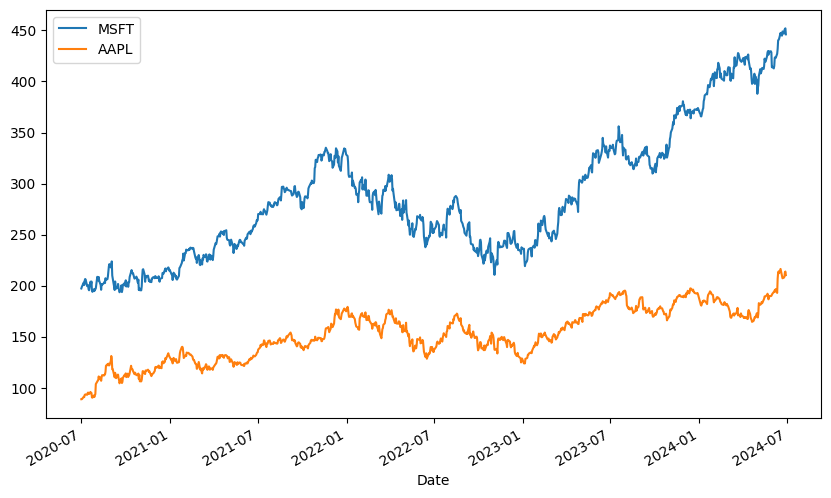

In [64]:
stock_port.plot(x = 'Date', y = ['MSFT', 'AAPL'], figsize=(10, 6))
#plt.figure(figsize=(14,7))
#plt.
#plt.plot(stock_port['MSFT'])
#plt.legend()
#plt.show()

In [65]:
print(stock_port['AAPL'].corr(stock_port['MSFT']))

0.8766638983558733


In [66]:
pip install statsmodels

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [67]:
from statsmodels.tsa.stattools import coint

In [68]:
score, p_val, _ = coint(stock_port['AAPL'], stock_port['MSFT'])
print(p_val)

0.06677540649920434


In [69]:
stock_port['spread'] = stock_port['AAPL'] - stock_port['MSFT']

In [73]:
spread_mean = stock_port['spread'].mean()
spread_std = stock_port['spread'].std()

print(spread_mean, spread_std)

-135.05716924714804 43.20898778483075


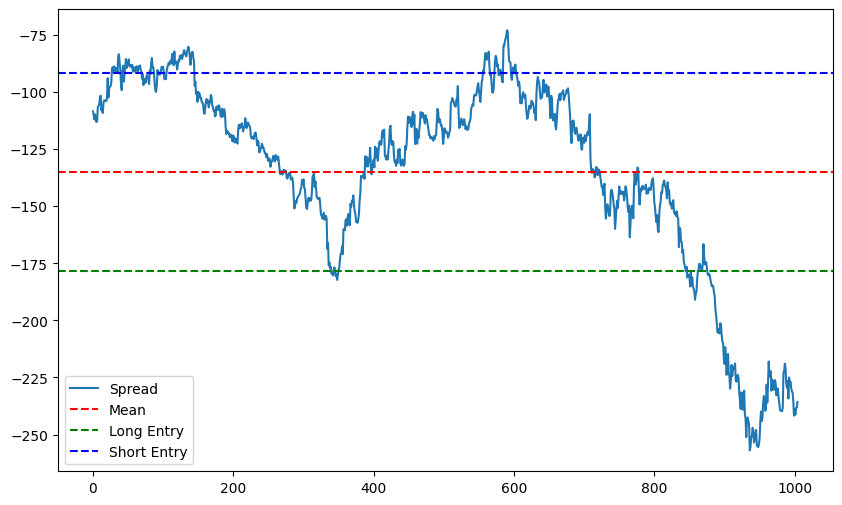

In [71]:
plt.figure(figsize=(10,6))
plt.plot(stock_port['spread'], label = 'Spread')
plt.axhline(spread_mean, color = 'red', linestyle = '--', label = 'Mean')
plt.axhline(spread_mean - spread_std, color = 'green', linestyle = '--', label = "Long Entry")
plt.axhline(spread_mean + spread_std, color = 'blue', linestyle = '--', label = 'Short Entry')
plt.legend()
plt.show()

In [72]:
stock_port = stock_port.assign(
    long_entry = stock_port['spread'] < (spread_mean - spread_std),
    long_exit = stock_port['spread'] >= spread_mean,
    short_entry = stock_port['spread'] > (spread_mean + spread_std),
    short_exit = spread_mean >= stock_port['spread']
)
stock_port

,Date,AAPL,MSFT,spread,long_entry,long_exit,short_entry,short_exit
0,2020-07-01,88.796066,197.268219,-108.472153,False,True,False,False
1,2020-07-02,88.796066,198.771561,-109.975494,False,True,False,False
2,2020-07-06,91.171356,203.050400,-111.879044,False,True,False,False
3,2020-07-07,90.888474,200.689316,-109.800842,False,True,False,False
4,2020-07-08,93.005295,205.103058,-112.097763,False,True,False,False
...,...,...,...,...,...,...,...,...
1000,2024-06-24,207.899353,446.864594,-238.965240,True,False,False,True
1001,2024-06-25,208.828293,450.138672,-241.310379,True,False,False,True
1002,2024-06-26,213.003448,451.346497,-238.343048,True,False,False,True
1003,2024-06-27,213.852478,452.035248,-238.182770,True,False,False,True


In [93]:
def back_test(stock_price1, stock_price2, long_entry, long_exit, short_entry, short_exit):
    #positions = np.zeros(len(stock_price1))
    positions = pd.Series(index = stock_price1.index, data = 0)
    #positions[long_entry] = 1
    #positions[short_entry] = -1
    #positions[long_exit] = 0
    #positions[short_exit] = 0

    cp = 0
    for i in range(1, len(stock_price1)):
        if long_entry.iloc[i] and cp == 0:
            cp = 1
        elif short_entry.iloc[i] and cp == 0:
            cp = -1
        elif long_exit.iloc[i] and cp == 1:
            cp = 0
        elif short_exit.iloc[i] and cp == -1:
            cp = 0
        
        positions.iloc[i] = cp

    returns_1 = stock_price1.pct_change().shift(-1)
    returns_2 = stock_price2.pct_change().shift(-1)
    #returns = np.diff(stock_price1) / stock_price1[:-1] - np.diff(stock_price2) / stock_price2[:-1]
    bt_returns = positions.shift(1) * (returns_1 - returns_2)

    #print(returns_1.head())
    #print(returns_2.head())
    #print(list(positions))

    return bt_returns.dropna()

In [99]:
bt_returns = back_test(stock_port['AAPL'], stock_port['MSFT'], stock_port['long_entry'], stock_port['long_exit'], stock_port['short_entry'], stock_port['short_exit'])

# Cummulative returns
cum_returns = (1 + bt_returns).cumprod() - 1
print(f'Cummulative returns: {cum_returns.iloc[-1]}')

# Sharpe ratio
rf = 0 # risk-free rate
sharpe_r = (bt_returns.mean() - rf)/ bt_returns.std()
print(f'Sharpe Ratio: {sharpe_r}')

# Maximum Drawdown
rolling_max = cum_returns.cummax()
drawdown = cum_returns - rolling_max
max_dd = drawdown.min()
print(f'Maximum Drawdown: {max_dd}')

Cummulative returns: 0.24597543015504697
Sharpe Ratio: 0.024948662390617136
Maximum Drawdown: -0.39418173188251004


In [98]:
# Filtering out days with no trading activity
def back_test1(stock_price1, stock_price2, long_entry, long_exit, short_entry, short_exit):
    #positions = np.zeros(len(stock_price1))
    positions = pd.Series(index = stock_price1.index, data = 0)
    #positions[long_entry] = 1
    #positions[short_entry] = -1
    #positions[long_exit] = 0
    #positions[short_exit] = 0

    cp = 0
    for i in range(1, len(stock_price1)):
        if long_entry.iloc[i] and cp == 0:
            cp = 1
        elif short_entry.iloc[i] and cp == 0:
            cp = -1
        elif long_exit.iloc[i] and cp == 1:
            cp = 0
        elif short_exit.iloc[i] and cp == -1:
            cp = 0
        
        positions.iloc[i] = cp

    returns_1 = stock_price1.pct_change().shift(-1)
    returns_2 = stock_price2.pct_change().shift(-1)
    #returns = np.diff(stock_price1) / stock_price1[:-1] - np.diff(stock_price2) / stock_price2[:-1]
    bt_returns = positions.shift(1) * (returns_1 - returns_2)

    #print(returns_1.head())
    #print(returns_2.head())
    #print(list(positions))

    return bt_returns[positions != 0].dropna()


bt_returns = back_test1(stock_port['AAPL'], stock_port['MSFT'], stock_port['long_entry'], stock_port['long_exit'], stock_port['short_entry'], stock_port['short_exit'])

# Cummulative returns
cum_returns = (1 + bt_returns).cumprod() - 1
print(f'Cummulative returns: {cum_returns.iloc[-1]}')

# Sharpe ratio
rf = 0 # risk-free rate
sharpe_r = (bt_returns.mean() - rf)/ bt_returns.std()
print(f'Sharpe Ratio: {sharpe_r}')

# Maximum Drawdown
rolling_max = cum_returns.cummax()
drawdown = cum_returns - rolling_max
max_dd = drawdown.min()
print(f'Maximum Drawdown: {max_dd}')

Cummulative returns: 0.27464423265059135
Sharpe Ratio: 0.034789692249985814
Maximum Drawdown: -0.4032515080154837


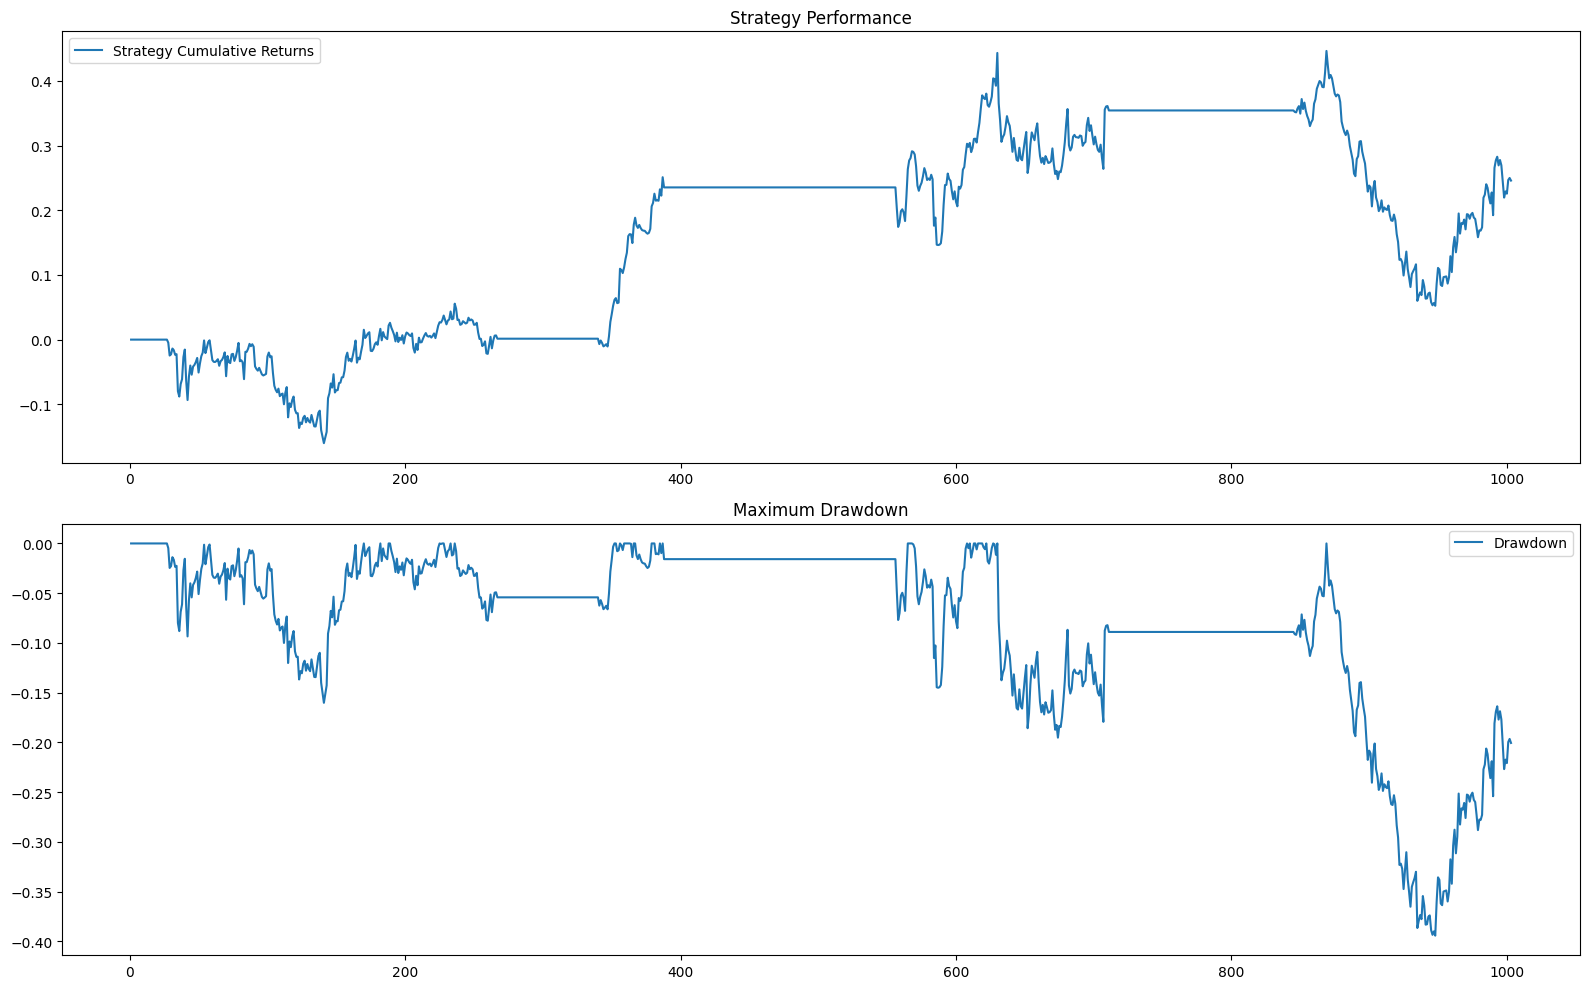

In [100]:
plt.figure(figsize=(16,10))

plt.subplot(2, 1, 1)
plt.plot(cum_returns, label = 'Strategy Cumulative Returns')
plt.title('Strategy Performance')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(drawdown, label = 'Drawdown')
plt.title('Maximum Drawdown')
plt.legend()

plt.tight_layout()
plt.show()